## Take FRC measurements on ROIs across an image using .h5r and .yaml recipes.

In [1]:
from __future__ import print_function; from PYME.recipes import modules; from PYME.LMVis import pipeline; 
import yaml; import sys; import ruamel.yaml; import matplotlib.cm as cm
data = pipeline.Pipeline("3_3_series_F.h5r") #Load the h5r file.
data.recipe.update_from_yaml('030320_sF_Fid_coalesce_ROI_SHAM_i3.yaml') # Load the recipe.
print("Available data sources: %s" % ', '.join(data.dataSources.keys())) # look at all the data sources we could select
data.selectDataSource('ROI')

Trying to load 3rd party recipe module PYMEcs.recipes.processing
Loaded 3rd party recipe module PYMEcs.recipes.processing
Trying to load 3rd party recipe module PYMEnf.recipes.pymenf
Loaded 3rd party recipe module PYMEnf.recipes.pymenf
Trying to load 3rd party recipe module PYMEcs.recipes.output
Loaded 3rd party recipe module PYMEcs.recipes.output
Trying to load 3rd party recipe module PYMEcs.recipes.localisations
Loaded 3rd party recipe module PYMEcs.recipes.localisations
Trying to load 3rd party recipe module PYMEcs.recipes.base
Loaded 3rd party recipe module PYMEcs.recipes.base
Drift fitting using qHull triangularisation
('parameters:', ['a', 'b', 'c'])
('parameters:', ['a', 'c'])


c:\users\work\documents\pyme_home\python-microscopy\PYME\IO\tabular.py:48: VisibleDeprecationWarning: mappingFilter is deprecated, use MappingFilter instead
  warnings.warn(VisibleDeprecationWarning('%s is deprecated, use %s instead' % (name, cls.__name__)))
c:\users\work\documents\pyme_home\pyme-extra\PYMEcs\Analysis\trackFiducials.py:152: RuntimeWarning: Mean of empty slice
  mm = np.nanmean(meas, 0)


Available data sources: ROI, drift_corrected, coalesced, corrected_fiducials, with_clumps, filtered_localizations, Localizations, mapped, find_fid, fiducialApplied, fiducialAdded, colour_mapped


## First step is to resize the image to something manageable. 
### For some annoying reason I haven't been able to work out how to add the FilterTable in the same style as other modules.. So, I am having to add to my recipe, save and then re-load it. I am sure there is an easy fix but have yet to look at it properly.

In [2]:
width = 3000; height = 3000 
x = data.x; y = data.y
x_delta = int(np.max(x))-int(np.min(x)); print ("Size of x", x_delta)
y_delta = int(np.max(y))-int(np.min(y)); print ("Size of y", y_delta)
column = int((x_delta)/width); row = int((y_delta)/height)
print ("Number of columns: ", column, "...  Number of rows: ", row)

x1 = int(np.min(x)); x2 = x1+((width*column)); x1_original = x1;
y1 = int(np.min(y)); y2 = y1+((height*row));   y1_original = y1;

x_delta = x2-x1; print ("New size of x", x_delta)
y_delta = y2-y1; print ("New size of y", y_delta)

Size of x 12216
Size of y 21611
Number of columns:  4 ...  Number of rows:  7
New size of x 12000
New size of y 21000


In [3]:
with open('030320_sF_Fid_coalesce_ROI_SHAM_i3.yaml') as f: #Load the recipe again 
    Resized = yaml.load(f, Loader=yaml.FullLoader)
    
record_to_add = dict({'tablefilters.FilterTable': {'outputName': 'Resized', 'inputName': 'ROI', 'filters': {'x': [x1, x2],'y': [y1, y2]}}})
yaml = ruamel.yaml.YAML()
yaml.explicit_start = True
Resized.append(record_to_add)
yaml.dump(Resized, sys.stdout)
with open('Resized.yaml', 'w') as file:
    Resized2 = yaml.dump(Resized, file)

---
- localisations.ProcessColour:
    input: Localizations
    species_ratios:
      RyR: 0.74
    species_dyes:
      RyR: ATTO655
    output: colour_mapped
- tablefilters.FilterTable:
    outputName: filtered_localizations
    inputName: colour_mapped
    filters:
      A:
      - 5.0
      - 3100000.0
      error_x:
      - 0
      - 30
      error_y:
      - 0
      - 30
- tablefilters.FilterTable:
    outputName: find_fid
    inputName: filtered_localizations
    filters:
      y:
      - 17112.0
      - 18001.0
      x:
      - 18830.0
      - 19630.0
      error_x:
      - 0.0
      - 4.1875
- localisations.FiducialTrack:
    outputName: fiducialAdded
    timeWindow: 250
    inputName: find_fid
- localisations.FiducialApplyFromFiducials:
    outputName: fiducialApplied
    outputFiducials: corrected_fiducials
    inputData: filtered_localizations
    inputFiducials: fiducialAdded
- pymenf.DriftCorrectModel:
    outputName: drift_corrected
    driftExprX: (cos(a)*x_raw + sin(a)*

## We now have a recipe that makes a ROI of a set size. Have to reload and apply the new recipe.

In [4]:
data.recipe.update_from_yaml('Resized.yaml')
print("Current data source: %s" % data.selectedDataSourceKey) # what is the currently selected data source
print("Available data sources: %s" % ', '.join(data.dataSources.keys())) # look at all the data sources we could select
data.selectDataSource('Resized')
print("Number of events in data source Resized is %d" % data.x.size)

('parameters:', ['a', 'b', 'c'])
('parameters:', ['a', 'c'])
Current data source: ROI
Available data sources: ROI, drift_corrected, coalesced, corrected_fiducials, with_clumps, Resized, filtered_localizations, Localizations, mapped, find_fid, fiducialApplied, fiducialAdded, colour_mapped
Number of events in data source Resized is 152760


### New recipe works. Now I want to add timeblock and generate an image to be used later.

[]
['fitResults_z0', 'fitResults_x0', 'clumpSize', 'focus', 'startParams_bg', 'startParams_dy', 'startParams_dx', 'resultCode', 'startParams_br', 'startParams_A', 'ratio', 'error_y', 'error_z', 'fitResults_dy', 'fitResults_br', 'trackVelocity', 'z_raw', 'tIndex', 'startParams_x0', 'fitResults_bg', 'fiducial_x', 'A', 'clumpIndex', 'fitResults_y0', 'nchi2', 'fiducial_z', 'subtractedBackground_r', 'fiducial_y', 'error_x', 'fitResults_A', 'x_raw', 'subtractedBackground_g', 'startParams_z0', 'drifty', 'driftx', 'driftz', 'y_raw', 't', 'fitResults_dx', 'y', 'x', 'z', 'startParams_y0']
Created colour filter with chans: ['block0', 'block1']


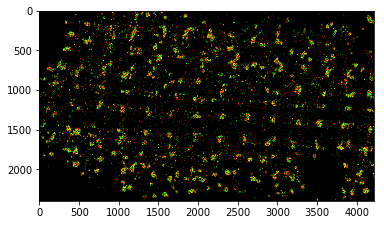

In [5]:
from PYME.recipes import localisations
tb = localisations.TimeBlocks(input='Resized',output='tbROI',
                                 block_size=100)
data.recipe.add_module(tb)
dm = localisations.DensityMapping(
        inputLocalizations='tbROI',
        jitterVariable="error_x",
        outputImage="FRC_entire_ROI",
        pixelSize=5.0,
        renderingModule='Gaussian',
        colours=['block0','block1'])
data.recipe.add_module(dm)
data.recipe.execute()
# CS code
def rgbwrap(r,g=None,b=None,vmax=None,vmin=None):
    if vmax is None:
        vmax = r.max()
    if vmin is None:
        vmin = r.min()
    rgbim = np.zeros(list(r.shape[0:2])+[3])
    rgbim[:,:,0] = (r-vmin)/(vmin+vmax)
    if not (g is None):
        rgbim[:,:,1] = (g-vmin)/(vmin+vmax)
    if not (b is None):
        rgbim[:,:,2] = (b-vmin)/(vmin+vmax)
    return rgbim

FRC_entire_ROI = data.dataSources['FRC_entire_ROI']
FRC_entire_ROI.data.shape

rgbim = rgbwrap(FRC_entire_ROI.data[:,:,0,0].squeeze(),FRC_entire_ROI.data[:,:,0,1].squeeze(),vmax=0.2)
plt.figure()
plt.imshow(rgbim)  ## Checking this looks about right. 

 ### Now to create the grid ROI - currently it will have to do to simply create a new recipe for each. 

In [6]:
x1 = x1_original; y1 = y1_original; l=0; px = 5
ROI_dict = {}
x1_values = []; x2_values = []; y1_values =[]; y2_values = []; centre_x =[]; centre_y=[]; coordinates_x=[];coordinates_y=[];
for i in range (column*row):
    import yaml
    with open('Resized.yaml') as f:
        ROI_finder = yaml.load(f, Loader=yaml.FullLoader)
    ROI_dict["ROI{0}".format(i)] = dict({'tablefilters.FilterTable': {'outputName': 'ROI_d', 'inputName': 'Resized', 'filters': {'x': [x1, x1+width],'y': [y1, y1+height]}}})
    yaml = ruamel.yaml.YAML()
    yaml.explicit_start = True
    ROI_finder.append(ROI_dict["ROI{0}".format(i)])
    yaml.dump(ROI_finder, sys.stdout)
    with open(r'recipes\ROI_%i.yaml' %i, 'w') as file:
        ROI_finder2 = yaml.dump(ROI_finder, file)
    x2_values.append(x1+width); y2_values.append(y1+height); 
    x1_values.append(x1); y1_values.append(y1);
    centre_x.append(((x1+((width)/2))-x1_original)/px); centre_y.append(((y1+((height)/2))-y1_original)/px);
    coordinates_x.append((centre_x[i]-(width/(2*px)))); coordinates_y.append((centre_y[i]-(height/(2*px))));
    x1 = x1+width
       
    print (i, l) #This checks whether the loop works correctly - l should equal number of rows -1 by the end of the loop.
    if x1 == (x1_original+(width*(column))):
        l = l+1; x1 = x1_original; y1 = y1_original+(height*l)

---
- localisations.ProcessColour:
    input: Localizations
    species_ratios:
      RyR: 0.74
    species_dyes:
      RyR: ATTO655
    output: colour_mapped
- tablefilters.FilterTable:
    outputName: filtered_localizations
    inputName: colour_mapped
    filters:
      A:
      - 5.0
      - 3100000.0
      error_x:
      - 0
      - 30
      error_y:
      - 0
      - 30
- tablefilters.FilterTable:
    outputName: find_fid
    inputName: filtered_localizations
    filters:
      y:
      - 17112.0
      - 18001.0
      x:
      - 18830.0
      - 19630.0
      error_x:
      - 0.0
      - 4.1875
- localisations.FiducialTrack:
    outputName: fiducialAdded
    timeWindow: 250
    inputName: find_fid
- localisations.FiducialApplyFromFiducials:
    outputName: fiducialApplied
    outputFiducials: corrected_fiducials
    inputData: filtered_localizations
    inputFiducials: fiducialAdded
- pymenf.DriftCorrectModel:
    outputName: drift_corrected
    driftExprX: (cos(a)*x_raw + sin(a)*

    outputName: fiducialAdded
    timeWindow: 250
    inputName: find_fid
- localisations.FiducialApplyFromFiducials:
    outputName: fiducialApplied
    outputFiducials: corrected_fiducials
    inputData: filtered_localizations
    inputFiducials: fiducialAdded
- pymenf.DriftCorrectModel:
    outputName: drift_corrected
    driftExprX: (cos(a)*x_raw + sin(a)*y_raw)+2300
    driftExprY: (cos(a)*y_raw - sin(a)*x_raw)
    inputName: mapped
    driftCorrParams:
      a: -0.5
      c: 0.0
- tablefilters.Mapping:
    outputName: mapped
    inputName: coalesced
- tracking.FindClumps:
    outputName: with_clumps
    inputName: fiducialApplied
    outputClumps: ''
- localisations.MergeClumps:
    outputName: coalesced
    inputName: with_clumps
- tablefilters.FilterTable:
    outputName: ROI
    inputName: drift_corrected
    filters:
      y:
      - 6934.0
      - 28404.0
      x:
      - 488.0
      - 12490.0
      z:
      - -150.0
      - 500.0
      t:
      - 0.0
      - 50000.0
      n

    driftExprX: (cos(a)*x_raw + sin(a)*y_raw)+2300
    driftExprY: (cos(a)*y_raw - sin(a)*x_raw)
    inputName: mapped
    driftCorrParams:
      a: -0.5
      c: 0.0
- tablefilters.Mapping:
    outputName: mapped
    inputName: coalesced
- tracking.FindClumps:
    outputName: with_clumps
    inputName: fiducialApplied
    outputClumps: ''
- localisations.MergeClumps:
    outputName: coalesced
    inputName: with_clumps
- tablefilters.FilterTable:
    outputName: ROI
    inputName: drift_corrected
    filters:
      y:
      - 6934.0
      - 28404.0
      x:
      - 488.0
      - 12490.0
      z:
      - -150.0
      - 500.0
      t:
      - 0.0
      - 50000.0
      nchi2:
      - 1.5
      - 2.4
- tablefilters.FilterTable:
    outputName: Resized
    inputName: ROI
    filters:
      y:
      - 6888
      - 27888
      x:
      - 232
      - 12232
- tablefilters.FilterTable:
    outputName: ROI_d
    inputName: Resized
    filters:
      y:
      - 12888
      - 15888
      x:
      

      - 12232
- tablefilters.FilterTable:
    outputName: ROI_d
    inputName: Resized
    filters:
      y:
      - 15888
      - 18888
      x:
      - 232
      - 3232
12 3
---
- localisations.ProcessColour:
    input: Localizations
    species_ratios:
      RyR: 0.74
    species_dyes:
      RyR: ATTO655
    output: colour_mapped
- tablefilters.FilterTable:
    outputName: filtered_localizations
    inputName: colour_mapped
    filters:
      A:
      - 5.0
      - 3100000.0
      error_x:
      - 0
      - 30
      error_y:
      - 0
      - 30
- tablefilters.FilterTable:
    outputName: find_fid
    inputName: filtered_localizations
    filters:
      y:
      - 17112.0
      - 18001.0
      x:
      - 18830.0
      - 19630.0
      error_x:
      - 0.0
      - 4.1875
- localisations.FiducialTrack:
    outputName: fiducialAdded
    timeWindow: 250
    inputName: find_fid
- localisations.FiducialApplyFromFiducials:
    outputName: fiducialApplied
    outputFiducials: corrected_fiduc

- tablefilters.FilterTable:
    outputName: filtered_localizations
    inputName: colour_mapped
    filters:
      A:
      - 5.0
      - 3100000.0
      error_x:
      - 0
      - 30
      error_y:
      - 0
      - 30
- tablefilters.FilterTable:
    outputName: find_fid
    inputName: filtered_localizations
    filters:
      y:
      - 17112.0
      - 18001.0
      x:
      - 18830.0
      - 19630.0
      error_x:
      - 0.0
      - 4.1875
- localisations.FiducialTrack:
    outputName: fiducialAdded
    timeWindow: 250
    inputName: find_fid
- localisations.FiducialApplyFromFiducials:
    outputName: fiducialApplied
    outputFiducials: corrected_fiducials
    inputData: filtered_localizations
    inputFiducials: fiducialAdded
- pymenf.DriftCorrectModel:
    outputName: drift_corrected
    driftExprX: (cos(a)*x_raw + sin(a)*y_raw)+2300
    driftExprY: (cos(a)*y_raw - sin(a)*x_raw)
    inputName: mapped
    driftCorrParams:
      a: -0.5
      c: 0.0
- tablefilters.Mapping:
    out

- pymenf.DriftCorrectModel:
    outputName: drift_corrected
    driftExprX: (cos(a)*x_raw + sin(a)*y_raw)+2300
    driftExprY: (cos(a)*y_raw - sin(a)*x_raw)
    inputName: mapped
    driftCorrParams:
      a: -0.5
      c: 0.0
- tablefilters.Mapping:
    outputName: mapped
    inputName: coalesced
- tracking.FindClumps:
    outputName: with_clumps
    inputName: fiducialApplied
    outputClumps: ''
- localisations.MergeClumps:
    outputName: coalesced
    inputName: with_clumps
- tablefilters.FilterTable:
    outputName: ROI
    inputName: drift_corrected
    filters:
      y:
      - 6934.0
      - 28404.0
      x:
      - 488.0
      - 12490.0
      z:
      - -150.0
      - 500.0
      t:
      - 0.0
      - 50000.0
      nchi2:
      - 1.5
      - 2.4
- tablefilters.FilterTable:
    outputName: Resized
    inputName: ROI
    filters:
      y:
      - 6888
      - 27888
      x:
      - 232
      - 12232
- tablefilters.FilterTable:
    outputName: ROI_d
    inputName: Resized
    f

- tablefilters.FilterTable:
    outputName: Resized
    inputName: ROI
    filters:
      y:
      - 6888
      - 27888
      x:
      - 232
      - 12232
- tablefilters.FilterTable:
    outputName: ROI_d
    inputName: Resized
    filters:
      y:
      - 24888
      - 27888
      x:
      - 3232
      - 6232
25 6
---
- localisations.ProcessColour:
    input: Localizations
    species_ratios:
      RyR: 0.74
    species_dyes:
      RyR: ATTO655
    output: colour_mapped
- tablefilters.FilterTable:
    outputName: filtered_localizations
    inputName: colour_mapped
    filters:
      A:
      - 5.0
      - 3100000.0
      error_x:
      - 0
      - 30
      error_y:
      - 0
      - 30
- tablefilters.FilterTable:
    outputName: find_fid
    inputName: filtered_localizations
    filters:
      y:
      - 17112.0
      - 18001.0
      x:
      - 18830.0
      - 19630.0
      error_x:
      - 0.0
      - 4.1875
- localisations.FiducialTrack:
    outputName: fiducialAdded
    timeWindow

## We now have a grid of smaller ROIs. Current size 3k pixel x 3k pixel. 
### Next is to add timeblock and do the FRC for each of the ROI.

In [7]:
FRC_values=[]; print(column*row);
for i in range (column*row):
    data = pipeline.Pipeline("3_3_series_F.h5r")  
    data.recipe.update_from_yaml(r'recipes\ROI_%i.yaml' %i)
    data.selectDataSource('ROI_d')
    from PYME.recipes import localisations
    tb = localisations.TimeBlocks(input='ROI_d',output='tbROI',block_size=100)
    data.recipe.add_module(tb)
    dm = localisations.DensityMapping(
        inputLocalizations='tbROI',
        jitterVariable="error_x",
        outputImage="FRCROI",
        pixelSize=5.0,
        renderingModule='Gaussian',
        colours=['block0','block1'])
    data.recipe.add_module(dm)
    data.recipe.execute()
    image = data.dataSources['FRCROI']
    from PYMEcs.experimental import FRC
    freqs,frc1,smoothed,fhb,f7,halfbit = FRC.frc_from_image(image,[0,1])
    print('res-1/7     = %3.1f nm' % (1.0/f7[0])); print (i)
    FRC_value_in_nm = round((1.0/f7[0]),1)
    FRC_values.append(FRC_value_in_nm);

28
('parameters:', ['a', 'b', 'c'])
('parameters:', ['a', 'c'])
[]
['fitResults_z0', 'fitResults_x0', 'clumpSize', 'focus', 'startParams_bg', 'startParams_dy', 'startParams_dx', 'resultCode', 'startParams_br', 'startParams_A', 'ratio', 'error_y', 'error_z', 'fitResults_dy', 'fitResults_br', 'trackVelocity', 'z_raw', 'tIndex', 'startParams_x0', 'fitResults_bg', 'fiducial_x', 'A', 'clumpIndex', 'fitResults_y0', 'nchi2', 'fiducial_z', 'subtractedBackground_r', 'fiducial_y', 'error_x', 'fitResults_A', 'x_raw', 'subtractedBackground_g', 'startParams_z0', 'drifty', 'driftx', 'driftz', 'y_raw', 't', 'fitResults_dx', 'y', 'x', 'z', 'startParams_y0']
Created colour filter with chans: ['block0', 'block1']
res-1/7     = 40.3 nm
0
('parameters:', ['a', 'b', 'c'])
('parameters:', ['a', 'c'])
[]
['fitResults_z0', 'fitResults_x0', 'clumpSize', 'focus', 'startParams_bg', 'startParams_dy', 'startParams_dx', 'resultCode', 'startParams_br', 'startParams_A', 'ratio', 'error_y', 'error_z', 'fitResults_dy',

res-1/7     = 35.2 nm
11
('parameters:', ['a', 'b', 'c'])
('parameters:', ['a', 'c'])
[]
['fitResults_z0', 'fitResults_x0', 'clumpSize', 'focus', 'startParams_bg', 'startParams_dy', 'startParams_dx', 'resultCode', 'startParams_br', 'startParams_A', 'ratio', 'error_y', 'error_z', 'fitResults_dy', 'fitResults_br', 'trackVelocity', 'z_raw', 'tIndex', 'startParams_x0', 'fitResults_bg', 'fiducial_x', 'A', 'clumpIndex', 'fitResults_y0', 'nchi2', 'fiducial_z', 'subtractedBackground_r', 'fiducial_y', 'error_x', 'fitResults_A', 'x_raw', 'subtractedBackground_g', 'startParams_z0', 'drifty', 'driftx', 'driftz', 'y_raw', 't', 'fitResults_dx', 'y', 'x', 'z', 'startParams_y0']
Created colour filter with chans: ['block0', 'block1']
res-1/7     = 65.1 nm
12
('parameters:', ['a', 'b', 'c'])
('parameters:', ['a', 'c'])
[]
['fitResults_z0', 'fitResults_x0', 'clumpSize', 'focus', 'startParams_bg', 'startParams_dy', 'startParams_dx', 'resultCode', 'startParams_br', 'startParams_A', 'ratio', 'error_y', 'err

res-1/7     = 34.1 nm
23
('parameters:', ['a', 'b', 'c'])
('parameters:', ['a', 'c'])
[]
['fitResults_z0', 'fitResults_x0', 'clumpSize', 'focus', 'startParams_bg', 'startParams_dy', 'startParams_dx', 'resultCode', 'startParams_br', 'startParams_A', 'ratio', 'error_y', 'error_z', 'fitResults_dy', 'fitResults_br', 'trackVelocity', 'z_raw', 'tIndex', 'startParams_x0', 'fitResults_bg', 'fiducial_x', 'A', 'clumpIndex', 'fitResults_y0', 'nchi2', 'fiducial_z', 'subtractedBackground_r', 'fiducial_y', 'error_x', 'fitResults_A', 'x_raw', 'subtractedBackground_g', 'startParams_z0', 'drifty', 'driftx', 'driftz', 'y_raw', 't', 'fitResults_dx', 'y', 'x', 'z', 'startParams_y0']
Created colour filter with chans: ['block0', 'block1']
res-1/7     = 46.1 nm
24
('parameters:', ['a', 'b', 'c'])
('parameters:', ['a', 'c'])
[]
['fitResults_z0', 'fitResults_x0', 'clumpSize', 'focus', 'startParams_bg', 'startParams_dy', 'startParams_dx', 'resultCode', 'startParams_br', 'startParams_A', 'ratio', 'error_y', 'err

## Plot the FRC figure from earlier. Overlay with a grid, displaying the FRC values and apply a colour map to the results. 

65.1


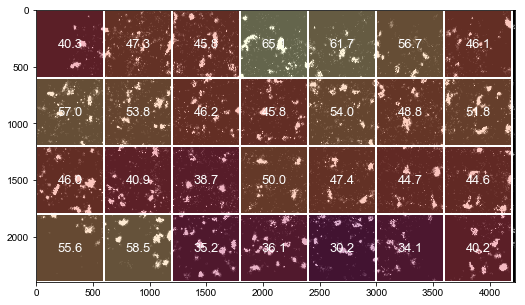

In [13]:
FRC_max = np.max(FRC_values); print (FRC_max); FRC_norm = FRC_values/FRC_max
width_sc = width/px; height_sc = height/px
plt.rcParams['font.family']='arial'
flatim = FRC_entire_ROI.data[:,:,0,0].squeeze()+FRC_entire_ROI.data[:,:,0,1].squeeze()
plt.figure(figsize = (10,5))
plt.imshow(flatim,cmap='gray',vmax=0.5)
for i in range (column*row):
    plt.text(centre_y[i],centre_x[i], str(FRC_values[i]), fontsize=13, horizontalalignment='center',verticalalignment='center', color = "white", alpha = 1,bbox=dict(facecolor='black', alpha=0.0))
fill=[]
for i in range (column*row):
    fill.append(plt.Rectangle((coordinates_y[i],coordinates_x[i]), width_sc, height_sc,
                              fc=cm.magma(FRC_norm[i], 0.4),ec="white", linewidth=2)) #Yellow -> Red -> Purple
    plt.gca().add_patch(fill[i])